In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from torch import tensor

### A naive example of convolution: applying a 3x3 kernel over a 7x7 image block
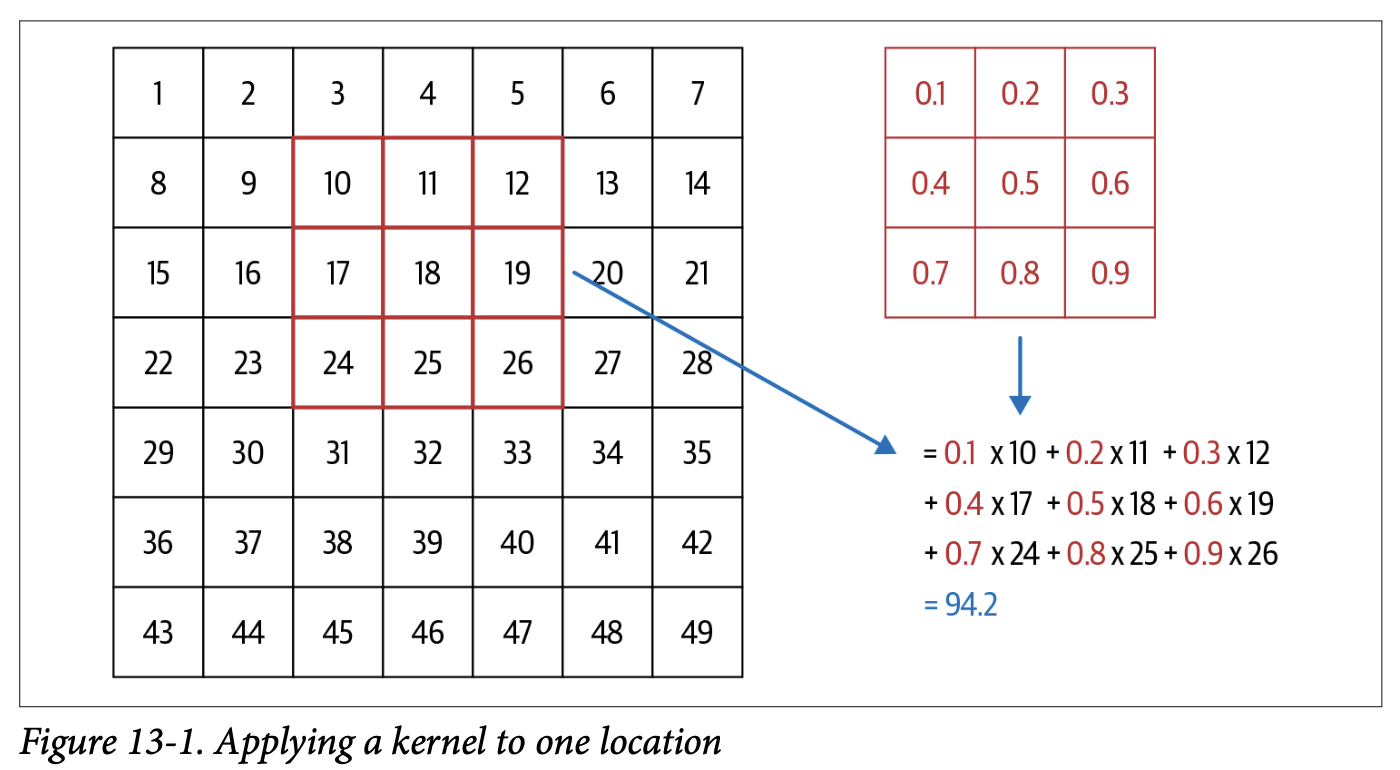


In [3]:
top_edge = tensor([[-1,-1,-1],
                  [0,0,0],
                   [1,1,1]]).float()
# this is called kernel

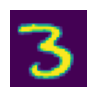

In [4]:
from fastai.vision.all import *
path = untar_data(URLs.MNIST_SAMPLE)

im3 = Image.open(path/"train"/"3"/"12.png")
show_image(im3);

In [5]:
im3_t = tensor(im3)
im3_t[0:3, 0:3] * top_edge

# all the pixels in the top-left cormer are white


tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [6]:
(im3_t[0:3, 0:3]*top_edge).sum() 



tensor(0.)

In [7]:
df=pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{"font-size":"6pt"}).background_gradient("Greys")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


Patch at (5,7) convolution sum: 762.0


<Axes: title={'center': 'Sum=762.0'}>

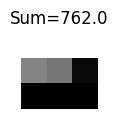

In [8]:
patch1 = im3_t[4:7,  6:9]           # (3,3)
val1   = (patch1 * top_edge).sum()
print("Patch at (5,7) convolution sum:", val1.item())
show_image(patch1.unsqueeze(0), title=f"Sum={val1.item():.1f}", cmap='Greys')


Patch at (8,18) convolution sum: -29.0


<Axes: title={'center': 'Sum=-29.0'}>

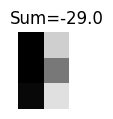

In [9]:
# Patch 2: (8,18)
patch2 = im3_t[7:10, 17:20]         # (3,3)
val2   = (patch2 * top_edge).sum()
print("Patch at (8,18) convolution sum:", val2.item())
show_image(patch2.unsqueeze(0), title=f"Sum={val2.item():.1f}", cmap='Greys')

If we change the filter to the one that has the row of 1s at the top and -1s at the bottom, it would detect horizontal edges that go from dark to light

In [10]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2, col-1:col+2]*kernel).sum()

apply_kernel(5,7, top_edge)

#

tensor(762.)

#### Note: We can't apply applt_kernel() to the corner since there is no complete 3x3 square there
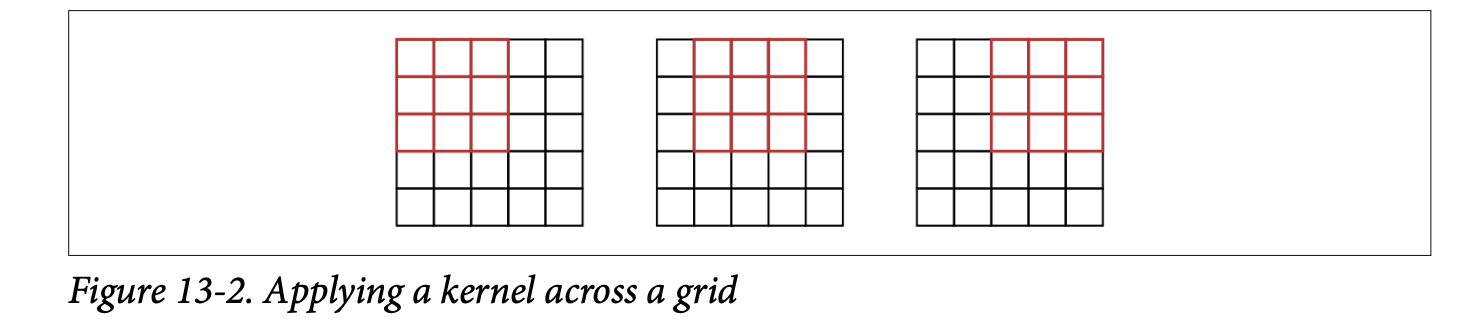
we can map apply_kernel() accross the coordinate grid like this

In [11]:
[[(i,j) for j in range(1,5)] for i in range(1,5)]
# a nested list comprehension

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

In [12]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])



<Axes: >

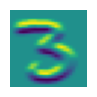

In [13]:
show_image(top_edge3) 


## Convolution Output Size Calculation

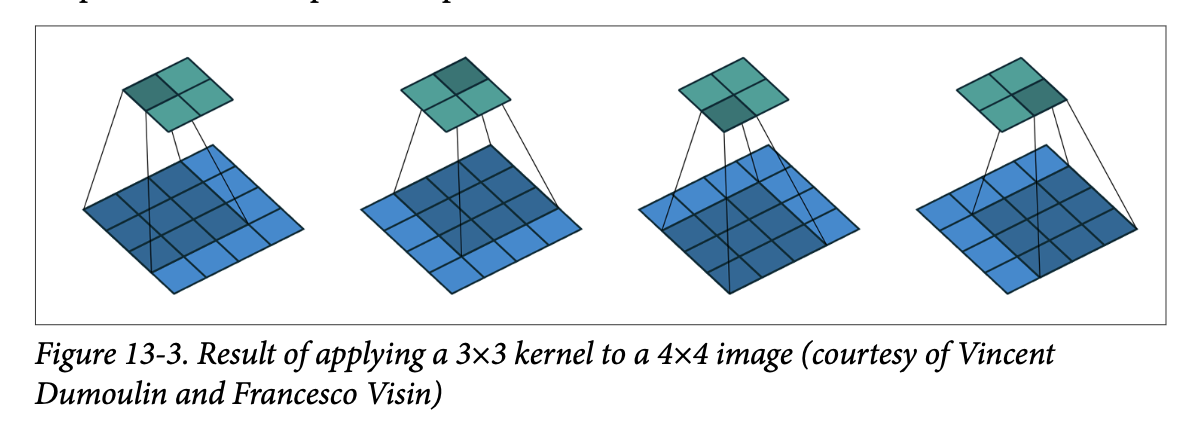
### 1. Example: 4×4 Image with 3×3 Kernel
- Given a **4×4** input image (blue) and a **3×3** kernel (dark blue),  
- We slide the kernel over all valid 3×3 patches (no padding, stride=1), performing 4 convolutions total,  
- Producing a **2×2** activation map (green).

The four window positions (left → right, top → bottom) are:
1. Image patch covering rows 1–3 and cols 1–3  
2. Image patch covering rows 1–3 and cols 2–4  
3. Image patch covering rows 2–4 and cols 1–3  
4. Image patch covering rows 2–4 and cols 2–4  

Since  
- horizontal positions = \(4 - 3 + 1 = 2\)  
- vertical positions   = \(4 - 3 + 1 = 2\)  
we obtain \(2 \times 2 = 4\) windows.

---

### 2. General Formula (padding = 0, stride = 1)

For an input of height \(h\) and width \(w\), with a \(k \times k\) kernel, no padding, and stride \(s = 1\):

$$
\text{output\_height} = h - k + 1, \quad
\text{output\_width}  = w - k + 1
$$

- **Example**: If \(k = 3\), then  
  $$
  \(\text{output\_height} = h - 2,\;\text{output\_width} = w - 2\)
  $$,  
  so the activation map size is \((h-2)\times(w-2)\).

---

### 3. Why Use `nn.Conv2d` in Practice?

- **Speed**: Pure Python loops are orders of magnitude slower compared to C/CUDA-optimized kernels.  
- **Reliability**: Handles padding, stride, dilation, groups, and other options consistently.  
- **Convenience**: A single layer call abstracts away complex indexing and broadcasting.

```python
import torch.nn as nn
conv = nn.Conv2d(in_channels=1, out_channels=16,
                 kernel_size=3, stride=1, padding=0)
# Automatically computes (h-2)×(w-2) output for a k=3 kernel
```

## 4. Summary

1. **Number of windows**:  
   $$
   (h - k + 1)\;\times\;(w - k + 1)
   $$

2. **Example**:  
   - 4×4 image + 3×3 kernel → 2×2 output

3. **In practice**:  
   - Compute shapes using the formula above,  
   - Then use `nn.Conv2d` for efficient implementation  

---

**Why these formulas matter:**  
- **Predict feature map sizes** when stacking multiple convolutional layers  
- **Understand the effects** of padding and stride on output dimensions  
- **Debug shape mismatches** quickly during model development  
- **Gain intuition** about what convolution layers are doing under the hood  

## Convolutions in PyTorch

- **Input tensor shape**:  (batch_size, in_channels, height, width)
    - `batch_size`: number of images in the batch  
    - `in_channels`: channels per image (e.g. 1 for grayscale, 3 for RGB)  
    - `height, width`: spatial dimensions of each image  

/
- **Kernel (weight) tensor shape**: (out_channels, in_channels, kH, kW)
    - `out_channels`: number of filters this layer learns  
    - `in_channels`: must match the input’s channel count  
    - `kH, kW`: kernel height and width (e.g. 3, 3)  

- **Why 4D tensors?**  
1. **Batch processing**: apply convolution to every image in one call  
2. **Multiple filters**: compute all `out_channels` feature maps at once  

```python
# Example: 8 MNIST images, 1 input channel, 28×28 resolution
x.shape             # torch.Size([8, 1, 28, 28])

# Stack four 3×3 edge detectors into one tensor of shape (4, 1, 3, 3)
edge_kernels.shape  # torch.Size([4, 1, 3, 3])

In [18]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()
diag1_edge = tensor([[0,-1,1],
                    [-1,1,0],
                    [1,0,0]]).float()
diag2_edge = tensor([[1,-1,0],
                     [0,1,-1],
                     [0,0,1]]).float()

In [19]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape # 4 filters(kernels), 3*3 each 

torch.Size([4, 3, 3])

In [23]:
from fastai.vision.all import *
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock),
                 get_items=get_image_files,
                 splitter=GrandparentSplitter(), # split train/valid based on grandparent folder names
                 get_y=parent_label) # use the **parent** folder name (e.g. "3", "7") as the label

dls=mnist.dataloaders(path)
# Create two DataLoaders according to these rules:
#   - dls.train : training DataLoader
#   - dls.valid : validation DataLoader

xb,yb=first(dls.valid) # first(..): gets 1st batch from DataLoader where xb: batch of images, yb: batch of labels
xb.shape # ([64, 1, 28, 28]) --> 64 images (for one batch), 1 channel(black&white), 28*28 pixel image

torch.Size([64, 1, 28, 28])

Because xb has shape (64, 1, 28, 28) — 64 images per batch, 1 channel each, 28×28 pixels — it exactly matches the expected input shape for F.conv2d(xb, weight).

In [ ]:
xb, yb = to_cpu(xb), to_cpu(yb) 

- Once you define a FastAI `DataBlock`:
  - **Dataset splitting**, **label extraction**, and **batch creation** all happen automatically.  
  - The batches emitted by its `DataLoader` are shaped exactly as PyTorch convolution layers expect:  
    ```
    [batch_size, in_channels, height, width]
    ```  
  - Moving data between GPU and CPU is a one-line utility call (`to_cpu(...)`), making device management trivial.  

In [26]:
edge_kernels.shape, edge_kernels.unsqueeze(1).shape
# we simply stacked the kernels (the # of channels is missing)
# therefore we have to insert an axis of size one in the first location where the PyTorch docs show in_channels is expected
# To insert a unit axis into a tensor, we use the unsqueeze method


(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

torch.Size([4, 1, 3, 3]) is now the correct shape for edge_kernels
we'll pass this all to conv2d

In [27]:
edge_kernels=edge_kernels.unsqueeze(1) 

batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape # 64 images, 4 filters, 26*26 feature map 

torch.Size([64, 4, 26, 26])

- xb.shape == (64, 1, 28, 28) 
- edge_kernels.shape == (4, 1, 3, 3)
- batch_features.shape 64 images, 4 filters, 26*26 feature map
    - 26 = 28 - 2: we lose one pixel on each side (top/bottom or left/right),
    - so 28×28 input becomes 26×26 output when padding=0

<Axes: >

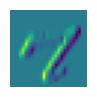

In [28]:
show_image(batch_features[0,0])
# batch_features[0,0]: feature map for the 1st image in the batch
# using the 1st filter → shape (26, 26)


## Strides and Padding 
### Padding 

- **Purpose**: Preserve spatial dimensions or control output size when convolving.  
- **General formula** (no stride, square kernel \(k\)):  
  $
    \text{out\_size} = (h + 2p) - k + 1
  $  
  where \(h\) = input size, \(p\) = padding on each side.

- **Same-size output** (common case):  
  - Use an **odd** kernel \(k\).  
  - Set  
    $
      p = \frac{k - 1}{2}
    $  
  - Then \(\text{out\_size} = h\).

- **Example**:  
  - \(h=28\), \(k=3\) → \(p=1\) → output = 28  
  - \(h=5\),  \(k=4\) → \(p=2\) → output = 6

- **PyTorch**:  
  ```python
  nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p)
  ```
  automatically adds (p) zero‐pixels around each image.
  
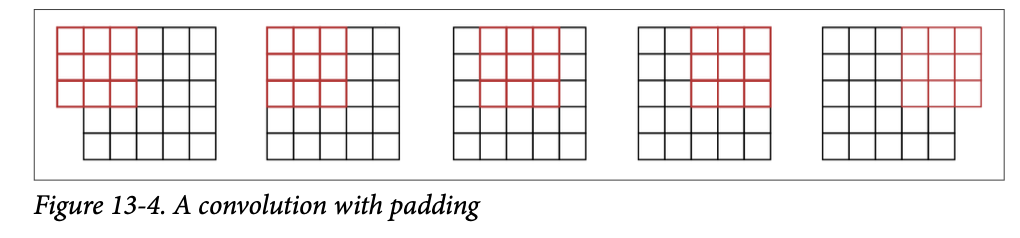


**The core idea of padding is to surround the image with zero (or other) pixels so that the kernel can be applied all the way to the edges without losing any information**

### Strides
Stride s controls how far the kernel moves at each step—i.e., it skips s-1 pixels between applications.

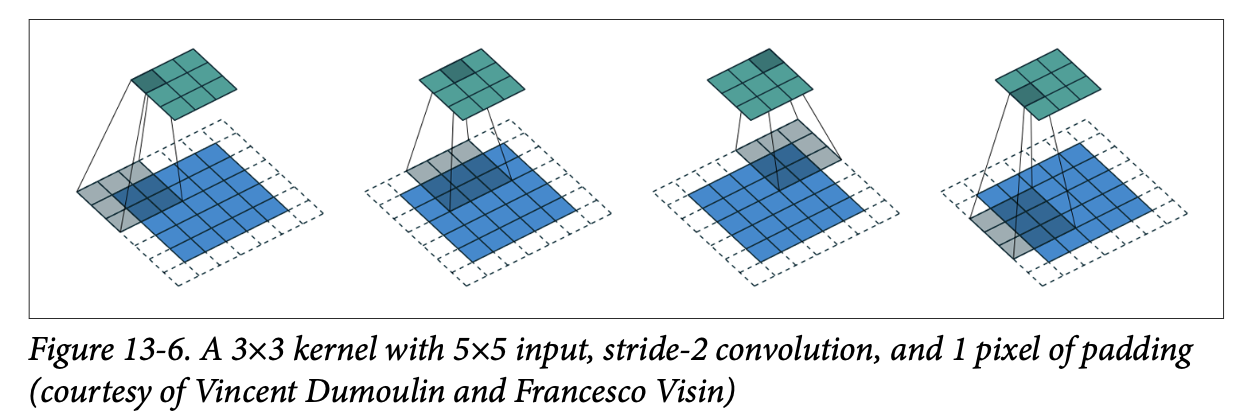


#### Common Practice

    - Most common settings  
      - Kernel: 3×3  
      - Padding: 1 → preserves spatial size when stride=1  
      - Stride: 2 → halves height & width of feature maps
    
    - Use cases  
      - Downsampling feature maps in lieu of pooling  
      - Reducing compute and memory by skipping positions


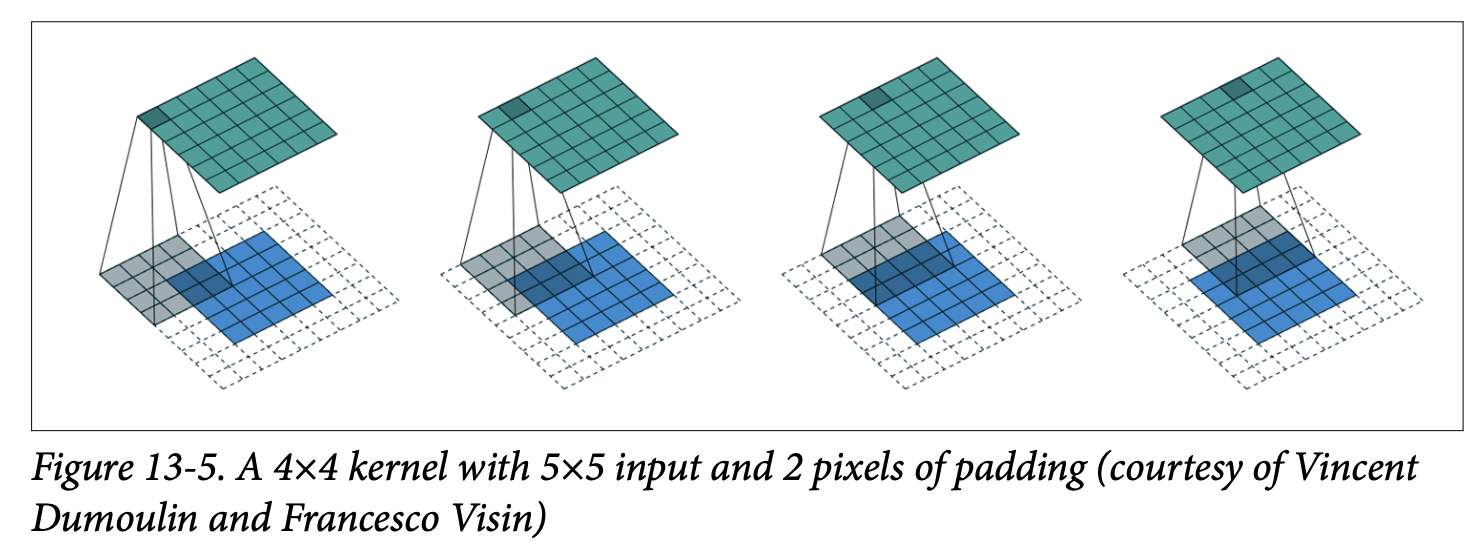